In [1]:
import torch
import random
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM, BertConfig, AdamW, DataCollatorForLanguageModeling
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
import tqdm
import shutil

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
def load_data(file_path, sample_size=20000, max_words=200):
    print("Loading data...")
    data = pd.read_json(file_path, lines=True)
    data = data[data['abstract'].apply(lambda x: len(x.split()) < max_words)]
    print("Data loaded and filtered.")
    return data.sample(sample_size)

# Dataset class
class BertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.padding = 'max_length'
        self.data = (df['abstract'] + " [SEP] " + df['title']).to_list()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = self.tokenizer(self.data, padding=self.padding, truncation=True, 
                                        max_length=self.max_length, return_tensors='pt')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].detach().clone()
        return item

# Model configuration
def configure_model(tokenizer):
    print("Configuring model...")
    config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=512,
        type_vocab_size=1,
        initializer_range=0.02
    )
    print("Model configured.")
    return BertForMaskedLM(config).to(device)

# Split data into training, validation, and test sets
def split_data(data, train_frac=0.8, val_frac=0.5):
    print("Splitting data into train, validation, and test sets...")
    train_data = data.sample(frac=train_frac, random_state=42)
    remaining_data = data.drop(train_data.index)
    val_data = remaining_data.sample(frac=val_frac, random_state=42)
    test_data = remaining_data.drop(val_data.index)
    print("Data split completed.")
    return train_data, val_data, test_data

# Create DataLoader
def create_dataloader(dataset, batch_size, shuffle, data_collator):
    print(f"Creating DataLoader with batch size {batch_size}...")
    return DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

def evaluate_model(model, data_loader, tokenizer, device, top_k=5):
    print("Evaluating model...")
    model.eval()
    total_loss = 0
    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Randomly mask a token for each sequence in the batch
            for i in range(input_ids.shape[0]):
                # Find all actual tokens (excluding padding)
                token_indices = torch.where(attention_mask[i] == 1)[0]
                # Now allow masking special tokens as well
                if len(token_indices) > 1:
                    random_mask_idx = random.choice(token_indices)
                    true_label = input_ids[i, random_mask_idx].item()
                    input_ids[i, random_mask_idx] = tokenizer.mask_token_id
                else:
                    continue

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits

            for i in range(input_ids.shape[0]):
                mask_idx = torch.where(input_ids[i] == tokenizer.mask_token_id)[0]
                if len(mask_idx) == 0:
                    continue  # No masked token found (unlikely but just to be safe)
                mask_idx = mask_idx[0]
                true_label = labels[i, mask_idx].item()
                pred_probs = F.softmax(logits[i, mask_idx], dim=-1)
                top_k_probs, top_k_indices = pred_probs.topk(top_k)

                if top_k_indices[0] == true_label:
                    total_correct += 1
                total_count += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_count if total_count > 0 else 0
    print(f"Evaluation completed. Loss: {avg_loss}, Accuracy: {accuracy}")
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, initial_lr, min_lr, n_epochs, model_name, patience=2, factor=5, start_epoch=0, writer=None):
    print("Starting training...")
    epochs_without_improvement = 0
    current_lr = initial_lr
    previous_val_accuracy = 0.0

    # Initialize TensorBoard writer if not provided
    if writer is None:
        writer = SummaryWriter(log_dir=f'runs/{model_name}')
    
    optimizer = AdamW(model.parameters(), lr=current_lr, weight_decay=0.01)

    for epoch in range(start_epoch, n_epochs):
        if current_lr < min_lr:
            print(f"Learning rate {current_lr} has fallen below the minimum learning rate {min_lr}. Stopping training.")
            break

        if epochs_without_improvement >= patience:
            print(f"Learning rate adjustment triggered after {patience} epochs without improvement.")
            current_lr /= factor
            optimizer = AdamW(model.parameters(), lr=current_lr, weight_decay=0.01)
            epochs_without_improvement = 0

        print(f"Epoch {epoch+1}/{n_epochs}, Learning rate: {current_lr}...")
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            model.zero_grad()
            outputs = model(**batch.to(device))
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, tokenizer, device)

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
        writer.add_scalar('Learning Rate', current_lr, epoch)

        model_save_path = f"{model_name}_epoch_{epoch+1}.pt"
        torch.save(model.state_dict(), model_save_path)
        print(f"Epoch {epoch+1} completed. Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Model saved to {model_save_path}")

        if epoch == 0 or val_accuracy > previous_val_accuracy:
            previous_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            previous_val_accuracy = val_accuracy
            print(f"Validation accuracy did not improve for {epochs_without_improvement} epoch(s).")

    writer.close()
    print("Training completed.")

# Function to display examples of data and model output
def display_examples(model, data_loader, tokenizer):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            predictions = outputs.logits.argmax(dim=-1)
            
            for i in range(min(3, len(input_ids))):  # Show at most 3 examples
                input_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                predicted_text = tokenizer.decode(predictions[i], skip_special_tokens=True)
                label_text = tokenizer.decode(labels[i], skip_special_tokens=True)
                
                print(f"Input Text: {input_text}")
                print(f"Predicted Text: {predicted_text}")
                print(f"Label Text: {label_text}")
                print("-" * 50)
            break  # Only process the first batch



2024-05-27 14:08:50.063335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:08:50.063457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:08:50.197613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [ ]:
# Main execution
if __name__ == "__main__":
    print("Starting main execution...")
    # Parameters
    FILE_PATH = '/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json'
    SAMPLE_SIZE = 25000
    MAX_WORDS = 200
    MAX_LENGTH = 512
    N_EPOCHS = 80
    BATCH_SIZE = 16
    INITIAL_LR = 4e-05
    MIN_LR = 1e-6
    WEIGHT_DECAY = 0.01
    MODEL_NAME = 'bert_model_citations'
    PATIENCE = 3
    FACTOR = 2

    # Load and prepare data
    data = load_data(FILE_PATH, SAMPLE_SIZE, MAX_WORDS)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_data, val_data, test_data = split_data(data)

    # Create datasets and dataloaders
    train_dataset = BertDataset(train_data, tokenizer, MAX_LENGTH)
    val_dataset = BertDataset(val_data, tokenizer, MAX_LENGTH)
    test_dataset = BertDataset(test_data, tokenizer, MAX_LENGTH)

    # Create data collator for masked language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.20
    )

    train_loader = create_dataloader(train_dataset, BATCH_SIZE, shuffle=True, data_collator=data_collator)
    val_loader = create_dataloader(val_dataset, BATCH_SIZE, shuffle=False, data_collator=data_collator)
    test_loader = create_dataloader(test_dataset, BATCH_SIZE, shuffle=False, data_collator=data_collator)

    # Configure model and optimizer
    model = configure_model(tokenizer)

    # Load the saved model state to resume training from epoch 32
    model.load_state_dict(torch.load('/kaggle/input/citations/pytorch/epoch40/1/bert_model_citations_epoch_40.pt'))

    # Copy the existing TensorBoard log to a writable directory
    src_log_dir = '/kaggle/input/tensorboard-logs/events.out.tfevents.1716317242.e0a4c831d927.24 (1).0'
    dst_log_dir = '/kaggle/working/tensorboard-log'
    if not os.path.exists(dst_log_dir):
        os.makedirs(dst_log_dir)
    shutil.copy(src_log_dir, dst_log_dir)

    # Initialize TensorBoard writer to append to existing log
    writer = SummaryWriter(log_dir=dst_log_dir, purge_step=40)

    # Display examples of data and model output
    display_examples(model, val_loader, tokenizer)

    # Train the model with dynamic learning rate adjustment, starting from epoch 32
    train_model(model, train_loader, val_loader, INITIAL_LR, MIN_LR, N_EPOCHS, MODEL_NAME, PATIENCE, FACTOR, start_epoch=40, writer=writer)

    # Evaluate the model
    val_loss, val_accuracy = evaluate_model(model, val_loader, tokenizer, device)
    test_loss, test_accuracy = evaluate_model(model, test_loader, tokenizer, device)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("Main execution completed.")


In [2]:
import torch
import random
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM, BertConfig, AdamW, DataCollatorForLanguageModeling
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
import tqdm
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=1,
    initializer_range=0.02
)

model = BertForMaskedLM(config=config).to(device)
model.load_state_dict(torch.load('/kaggle/input/citations/pytorch/epoch71/1/bert_model_citations_epoch_71.pt'))

cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<All keys matched successfully>

In [3]:
import torch.nn.functional as F

def model_predict_autoregressive(sentence_list, printer=False, top_k=5):
    n_correct = 0
    n_correct_top_k = 0
    true_labels = []
    total_predicted_tokens = 0
    eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
    
    model.eval()
    with torch.no_grad():
        for i in range(eval_tokenized['input_ids'].shape[0]):
            sep_token_indices = torch.where(eval_tokenized['input_ids'][i] == tokenizer.sep_token_id)[0]
            if len(sep_token_indices) > 0:
                sep_token_idx = sep_token_indices[0].item()  # Use the first [SEP] token index
            else:
                raise ValueError(f"[SEP] token not found in input sequence {i}")
                
            for j in range(sep_token_idx + 1, eval_tokenized['input_ids'].shape[1]):
                if eval_tokenized['input_ids'][i, j] == tokenizer.pad_token_id:
                    break
                true_token = eval_tokenized['input_ids'][i, j].item()
                true_labels.append(true_token)
                
                eval_tokenized['input_ids'][i, j] = tokenizer.mask_token_id
                eval_outputs = model(**eval_tokenized.to(device))
                eval_logits = eval_outputs['logits']
                
                eval_probs = torch.topk(F.softmax(eval_logits[i, j, :], dim=0), top_k).values    
                eval_preds = torch.topk(eval_logits[i, j, :], top_k).indices
                eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)
                
                if eval_preds[0].item() == true_token:
                    n_correct += 1
                if true_token in eval_preds.tolist():
                    n_correct_top_k += 1
                
                eval_tokenized['input_ids'][i, j] = true_token  # Replacing mask with the true token for next predictions
                
                if printer:
                    print(f"[{i}] SENTENCE.........:", sentence_list[i])
                    print(f"[{i}] MASKED TOKEN.....:", tokenizer.convert_ids_to_tokens(true_token))
                    print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
                    print(f"[{i}] CONFIDENCE:......:", [round(x, 2) for x in eval_probs.tolist()], '\n')
                
                total_predicted_tokens += 1  # Increment the count of predicted tokens
    
    accuracy = round(n_correct / total_predicted_tokens, 2) if total_predicted_tokens > 0 else 0
    accuracy_top_k = round(n_correct_top_k / total_predicted_tokens, 2) if total_predicted_tokens > 0 else 0
    
    print('ACCURACY.............:', accuracy)
    print(f"ACCURACY TOP {top_k}.......:", accuracy_top_k)
    
    return accuracy, accuracy_top_k


In [4]:
def load_data(file_path, sample_size=20000, max_words=200):
    print("Loading data...")
    data = pd.read_json(file_path, lines=True)
    data = data[data['abstract'].apply(lambda x: len(x.split()) < max_words)]
    print("Data loaded and filtered.")
    return data.sample(sample_size)

def split_data(data, train_frac=0.8, val_frac=0.5):
    print("Splitting data into train, validation, and test sets...")
    train_data = data.sample(frac=train_frac, random_state=42)
    remaining_data = data.drop(train_data.index)
    val_data = remaining_data.sample(frac=val_frac, random_state=42)
    test_data = remaining_data.drop(val_data.index)
    print("Data split completed.")
    return train_data, val_data, test_data

In [5]:
# eval_set = data['abstract'].sample(20).to_list()
data = load_data('/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json', 25000, 200)
train_data, val_data, test_data = split_data(data)
# eval_set = (data['abstract'] + "[SEP]" + data['title']).sample(20).to_list()
val_overlap = (train_data['abstract'] + "[SEP]" + train_data['title']).sample(2500).to_list()
# model_predict_autoregressive(val_overlap, printer=False, top_k=5)

Loading data...
Data loaded and filtered.
Splitting data into train, validation, and test sets...
Data split completed.


In [6]:
def model_predict(sentence_list, printer=False, top_k=5):
    n_correct = 0
    n_correct_top_k = 0
    true_labels = []
    eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
    
    # randomly masking tokens in each sentence
    for i in range(eval_tokenized['input_ids'].shape[0]):
        n_tokens = sum(eval_tokenized['attention_mask'][i])
        random_mask_idx = random.randint(1,n_tokens-2) # eliminating start & end tokens 
        true_token = eval_tokenized['input_ids'][i, random_mask_idx].item()
        true_labels += [true_token]
        eval_tokenized['input_ids'][i, random_mask_idx] = tokenizer.mask_token_id

    model.eval()
    with torch.no_grad():
        eval_outputs = model(**eval_tokenized.to(device))
    
    eval_logits = eval_outputs['logits']
    for i in range(len(sentence_list)):
        mask_idx = torch.where(eval_tokenized['input_ids'][i]==tokenizer.mask_token_id)[0].item()
        eval_probs = torch.topk(F.softmax(eval_logits[i, mask_idx, :],dim=0), top_k).values    
        eval_preds = torch.topk(eval_logits[i, mask_idx, :], top_k).indices
        eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)
        if(eval_preds[0].item()==true_labels[i]):
            n_correct += 1
        if(true_labels[i] in eval_preds.tolist()):
            n_correct_top_k += 1
        if(printer):
            print(f"[{i}] SENTENCE.........:", sentence_list[i])
            print(f"[{i}] MASKED TOKEN.....:", tokenizer.convert_ids_to_tokens(true_labels[i]))
            print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
            print(f"[{i}] CONFIDENCE:......:", [round(x, 2) for x in eval_probs.tolist()], '\n')
    print('ACCURACY.............:', round(n_correct/len(sentence_list),2))
    print(f"ACCURACY TOP {top_k}.......:", round(n_correct_top_k/len(sentence_list),2))
    return (n_correct/len(sentence_list), round(n_correct_top_k/len(sentence_list),2))

In [8]:
import torch
import random
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

# Load BERT model for sentence embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings of the [CLS] token
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_embedding

def sample_from_bin(bin_list, num_samples=3):
    if len(bin_list) < num_samples:
        return bin_list
    return random.sample(bin_list, num_samples)

def model_check_calibratedness(sentence_list, tokenizer, model, printer=False, top_k=5, temperatures=[1.0]):
    results = {}
    
    for temperature in temperatures:
        print(f"Running evaluation with temperature: {temperature}")
        exact_match_count = 0
        total_sentences = len(sentence_list)
        total_similarity_score = 0.0
        similarity_scores = []
        titles_info = []
        
        eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
        
        model.eval()
        with torch.no_grad():
            for i in range(eval_tokenized['input_ids'].shape[0]):
                sep_token_indices = torch.where(eval_tokenized['input_ids'][i] == tokenizer.sep_token_id)[0]
                if len(sep_token_indices) > 0:
                    sep_token_idx = sep_token_indices[0].item()  # Use the first [SEP] token index
                else:
                    raise ValueError(f"[SEP] token not found in input sequence {i}")

                current_input_ids = eval_tokenized['input_ids'][i].clone()
                generated_sentence = []
                j = sep_token_idx + 1

                while True:
                    if j >= eval_tokenized['input_ids'].shape[1] or current_input_ids[j] == tokenizer.pad_token_id:
                        break

                    true_token = eval_tokenized['input_ids'][i, j].item()

                    # Mask the current position
                    current_input_ids[j] = tokenizer.mask_token_id
                    
                    # Get model predictions
                    eval_outputs = model(input_ids=current_input_ids.unsqueeze(0).to(device))
                    eval_logits = eval_outputs['logits']

                    # Apply temperature to logits
                    eval_logits = eval_logits[0, j, :] / temperature
                    
                    # Get probabilities
                    eval_probs = torch.softmax(eval_logits, dim=0)

                    # Sample from the probability distribution
                    sampled_index = torch.multinomial(eval_probs, 1).item()

                    eval_preds = torch.topk(eval_logits, top_k).indices
                    eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)

                    # Append the predicted token to the generated sentence
                    generated_sentence.append(sampled_index)
                    
                    # Print the current input being used by the model
                    if printer:
                        input_so_far = tokenizer.convert_ids_to_tokens(current_input_ids[:j+1])
                        print(f"[{i}] INPUT TO MODEL...:", tokenizer.convert_ids_to_tokens(current_input_ids[:j]))
                        print(f"[{i}] SENTENCE.........:", sentence_list[i])
                        print(f"[{i}] TRUE TOKEN.......:", tokenizer.convert_ids_to_tokens([true_token]))
                        print(f"[{i}] PREDICTED TOKEN..:", tokenizer.convert_ids_to_tokens([sampled_index]))
                        print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
                        print(f"[{i}] CONFIDENCE:......:", [round(float(eval_probs[pred]), 2) for pred in eval_preds], '\n')
                    
                    # Replace mask with the predicted token for next input
                    current_input_ids[j] = sampled_index
                    
                    # Stop if the predicted token is the SEP token
                    if sampled_index == tokenizer.sep_token_id:
                        break
                    
                    j += 1  # Move to the next position

                # Convert generated tokens to string
                generated_sentence_str = tokenizer.decode(generated_sentence, skip_special_tokens=True)
                true_sentence_str = tokenizer.decode(eval_tokenized['input_ids'][i, sep_token_idx+1:], skip_special_tokens=True)

                # Skip if either the generated or true sentence is empty
                if not generated_sentence_str.strip() or not true_sentence_str.strip():
                    continue

                # Check for exact match
                if generated_sentence_str == true_sentence_str:
                    exact_match_count += 1
                    
                # Calculate similarity score (e.g., using cosine similarity on BERT embeddings)
                generated_embedding = get_sentence_embedding(generated_sentence_str, tokenizer, bert_model)
                true_embedding = get_sentence_embedding(true_sentence_str, tokenizer, bert_model)
                similarity_score = cosine_similarity(generated_embedding, true_embedding)[0][0]
                total_similarity_score += similarity_score
                
                # Store similarity score and titles
                similarity_scores.append(similarity_score)
                titles_info.append((similarity_score, generated_sentence_str, true_sentence_str))

        exact_match_accuracy = round(exact_match_count / total_sentences, 2) if total_sentences > 0 else 0
        avg_similarity_score = round(total_similarity_score / total_sentences, 2) if total_sentences > 0 else 0
        
        # Count samples in each similarity bin
        above_0_9 = [info for info in titles_info if info[0] > 0.9]
        between_0_9_and_0_7 = [info for info in titles_info if 0.9 >= info[0] >= 0.7]
        below_0_7 = [info for info in titles_info if info[0] < 0.7]

        print(f'Samples with similarity > 0.9: {len(above_0_9)}')
        print(f'Samples with similarity between 0.9 and 0.7: {len(between_0_9_and_0_7)}')
        print(f'Samples with similarity < 0.7: {len(below_0_7)}')

        # Randomly sample 3 from each bin
        sampled_above_0_9 = sample_from_bin(above_0_9)
        sampled_between_0_9_and_0_7 = sample_from_bin(between_0_9_and_0_7)
        sampled_below_0_7 = sample_from_bin(below_0_7)

        print('\nRandom samples with similarity > 0.9:')
        for score, generated, true in sampled_above_0_9:
            print(f"Score: {score:.4f}, Predicted: {generated}, True: {true}")
        
        print('\nRandom samples with similarity between 0.9 and 0.7:')
        for score, generated, true in sampled_between_0_9_and_0_7:
            print(f"Score: {score:.4f}, Predicted: {generated}, True: {true}")

        print('\nRandom samples with similarity < 0.7:')
        for score, generated, true in sampled_below_0_7:
            print(f"Score: {score:.4f}, Predicted: {generated}, True: {true}")
        
        results[temperature] = {
            'exact_match_accuracy': exact_match_accuracy,
            'avg_similarity_score': avg_similarity_score,
            'samples_above_0_9': sampled_above_0_9,
            'samples_between_0_9_and_0_7': sampled_between_0_9_and_0_7,
            'samples_below_0_7': sampled_below_0_7
        }

    return results


In [7]:
model_check_calibratedness(val_overlap, printer=False, top_k=5, temperature=0.6)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


EXACT MATCH ACCURACY.: 0.0
AVERAGE SIMILARITY...: 0.88


(0.0, 0.88)

In [9]:
val_non_overlap = (val_data['abstract'] + "[SEP]" + val_data['title']).to_list()
temperatures = [0.4]
results = model_check_calibratedness(val_non_overlap, tokenizer, model, printer=False, top_k=5, temperatures=temperatures)

Running evaluation with temperature: 0.4


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Samples with similarity > 0.9: 902
Samples with similarity between 0.9 and 0.7: 1586
Samples with similarity < 0.7: 10

Random samples with similarity > 0.9:
Score: 0.9246, Predicted: oxygen fugacities in extrasolar planets : evidence of the earth - rich serends in exoplanets., True: oxygen fugacities of extrasolar rocks : evidence for an earth - like geochemistry of exoplanets
Score: 0.9026, Predicted: the proper motions of hv2112 as a t \. zo12 in the sm. the, True: the proper motion of hv2112 : a t \. zo candidate in the smc
Score: 0.9123, Predicted: refinemask : a high - quality instance segmentation with fine - grained features,, True: refinemask : towards high - quality instance segmentation with fine - grained features

Random samples with similarity between 0.9 and 0.7:
Score: 0.8575, Predicted: direct enhancement of the spin - wave damping in a magnetic insulator :, True: electronic control of the spin - wave damping in a magnetic insulator
Score: 0.8908, Predicted: existence 

In [ ]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import random

# Load BERT model for sentence embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings of the [CLS] token
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_embedding

def sample_and_evaluate_titles(sentence_list, tokenizer, model, k=5, temperature=1.0):
    # Randomly sample k abstracts upfront
    sampled_indices = random.sample(range(len(sentence_list)), k)
    sampled_sentences = [sentence_list[i] for i in sampled_indices]
    
    similarity_scores = []
    titles_info = []
    
    eval_tokenized = tokenizer(sampled_sentences, padding='longest', truncation=True, return_tensors='pt')
    
    model.eval()
    with torch.no_grad():
        for i in range(eval_tokenized['input_ids'].shape[0]):
            sep_token_indices = torch.where(eval_tokenized['input_ids'][i] == tokenizer.sep_token_id)[0]
            if len(sep_token_indices) > 0:
                sep_token_idx = sep_token_indices[0].item()  # Use the first [SEP] token index
            else:
                raise ValueError(f"[SEP] token not found in input sequence {i}")

            current_input_ids = eval_tokenized['input_ids'][i].clone()
            generated_sentence = []
            j = sep_token_idx + 1

            while True:
                if j >= eval_tokenized['input_ids'].shape[1] or current_input_ids[j] == tokenizer.pad_token_id:
                    break

                true_token = eval_tokenized['input_ids'][i, j].item()

                # Mask the current position
                current_input_ids[j] = tokenizer.mask_token_id

                # Get model predictions
                eval_outputs = model(input_ids=current_input_ids.unsqueeze(0).to(device))
                eval_logits = eval_outputs['logits']

                # Apply temperature to logits
                eval_logits = eval_logits[0, j, :] / temperature

                # Get probabilities
                eval_probs = torch.softmax(eval_logits, dim=0)

                # Sample from the probability distribution
                sampled_index = torch.multinomial(eval_probs, 1).item()

                eval_preds = torch.topk(eval_logits, 5).indices
                eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)

                # Append the predicted token to the generated sentence
                generated_sentence.append(sampled_index)

                # Replace mask with the predicted token for next input
                current_input_ids[j] = sampled_index

                # Stop if the predicted token is the SEP token
                if sampled_index == tokenizer.sep_token_id:
                    break

                j += 1  # Move to the next position

            # Convert generated tokens to string
            generated_sentence_str = tokenizer.decode(generated_sentence, skip_special_tokens=True)
            true_sentence_str = tokenizer.decode(eval_tokenized['input_ids'][i, sep_token_idx + 1:], skip_special_tokens=True)

            # Skip if either the generated or true sentence is empty
            if not generated_sentence_str.strip() or not true_sentence_str.strip():
                continue

            # Calculate similarity score (e.g., using cosine similarity on BERT embeddings)
            generated_embedding = get_sentence_embedding(generated_sentence_str, tokenizer, bert_model)
            true_embedding = get_sentence_embedding(true_sentence_str, tokenizer, bert_model)
            similarity_score = cosine_similarity(generated_embedding, true_embedding)[0][0]
            
            # Store similarity score and titles
            titles_info.append((similarity_score, generated_sentence_str, true_sentence_str, sampled_sentences[i]))

    print('Randomly Sampled Abstracts and Titles:')
    for score, generated, true, abstract in titles_info:
        print(f"Abstract: {abstract}")
        print(f"Generated Title: {generated}")
        print(f"True Title: {true}")
        print(f"Similarity Score: {score:.4f}")
        print('-' * 50)

    return titles_info



In [23]:
sample_and_evaluate_titles(val_non_overlap, tokenizer, model, k=5)


Randomly Sampled Abstracts and Titles:
Abstract:   We prove a fractional version of the Hardy--Sobolev--Maz'ya inequality for
arbitrary domains and $L^p$ norms with $p\geq 2$. This inequality combines the
fractional Sobolev and the fractional Hardy inequality into a single
inequality, while keeping the sharp constant in the Hardy inequality.
[SEP]Fractional Hardy-Sobolev-Maz'ya inequality for domains
Generated Title: fractional hardy - sobolev - maz'ya inequality for domains with
True Title: fractional hardy - sobolev - maz'ya inequality for domains
Similarity Score: 0.9902
--------------------------------------------------
Abstract:   We present spectroscopic metallicities of individual stars in seven gas-rich
dwarf irregular galaxies (dIrrs), and we show that dIrrs obey the same
mass-metallicity relation as the dwarf spheroidal (dSph) satellites of both the
Milky Way and M31: Z_* ~ M_*^(0.30 +/- 0.02). The uniformity of the relation is
in contradiction to previous estimates of metall

[(0.99017286,
  "fractional hardy - sobolev - maz'ya inequality for domains with",
  "fractional hardy - sobolev - maz'ya inequality for domains",
  "  We prove a fractional version of the Hardy--Sobolev--Maz'ya inequality for\narbitrary domains and $L^p$ norms with $p\\geq 2$. This inequality combines the\nfractional Sobolev and the fractional Hardy inequality into a single\ninequality, while keeping the sharp constant in the Hardy inequality.\n[SEP]Fractional Hardy-Sobolev-Maz'ya inequality for domains"),
 (0.8700342,
  'a small - mass - stellar metallicity relation of dwarf galaxies in',
  'the universal stellar mass - stellar metallicity relation for dwarf galaxies',
  '  We present spectroscopic metallicities of individual stars in seven gas-rich\ndwarf irregular galaxies (dIrrs), and we show that dIrrs obey the same\nmass-metallicity relation as the dwarf spheroidal (dSph) satellites of both the\nMilky Way and M31: Z_* ~ M_*^(0.30 +/- 0.02). The uniformity of the relation is\nin 

### Evaluating Reliability Diagrams

In [9]:
MAX_LENGTH = 200
BATCH_SIZE = 16
val_dataset = BertDataset(val_data, tokenizer, MAX_LENGTH)
# Create data collator for masked language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.20
)
val_loader = create_dataloader(val_dataset, BATCH_SIZE, shuffle=False, data_collator=data_collator)


Creating DataLoader with batch size 16...


In [11]:
import numpy as np
import torch.nn.functional as F

def evaluate_model_with_predictions(model, data_loader, tokenizer, device, top_k=5):
    print("Evaluating model...")
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Randomly mask a token for each sequence in the batch
            for i in range(input_ids.shape[0]):
                # Find all actual tokens (excluding padding)
                token_indices = torch.where(attention_mask[i] == 1)[0]
                # Now allow masking special tokens as well
                if len(token_indices) > 1:
                    random_mask_idx = random.choice(token_indices)
                    true_label = input_ids[i, random_mask_idx].item()
                    input_ids[i, random_mask_idx] = tokenizer.mask_token_id
                else:
                    continue

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            for i in range(input_ids.shape[0]):
                mask_idx = torch.where(input_ids[i] == tokenizer.mask_token_id)[0]
                if len(mask_idx) == 0:
                    continue  # No masked token found (unlikely but just to be safe)
                mask_idx = mask_idx[0]
                true_label = labels[i, mask_idx].item()
                pred_probs = F.softmax(logits[i, mask_idx], dim=-1)
                top_k_probs, top_k_indices = pred_probs.topk(top_k)

                all_predictions.append(top_k_indices[0].cpu().numpy())
                all_labels.append(true_label)
                all_confidences.append(top_k_probs[0].cpu().numpy())

    return np.array(all_predictions), np.array(all_labels), np.array(all_confidences)

# Example usage:
predictions, labels, confidences = evaluate_model_with_predictions(model, val_loader, tokenizer, device)


Evaluating model...


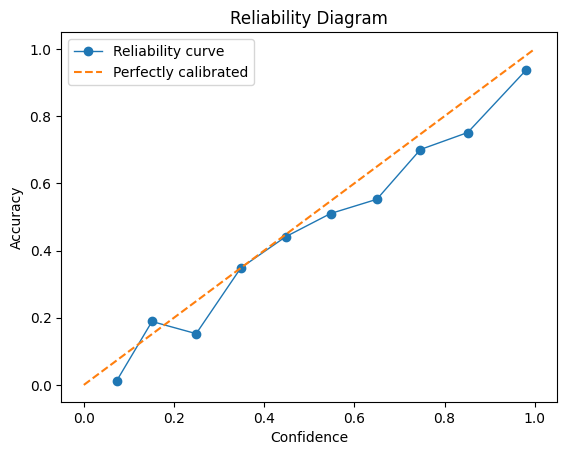

In [12]:
import matplotlib.pyplot as plt

def plot_reliability_diagram(predictions, labels, confidences, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies = (predictions == labels).astype(float)

    bin_accuracies = []
    bin_confidences = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) * (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            bin_accuracies.append(accuracy_in_bin)
            bin_confidences.append(avg_confidence_in_bin)

    plt.plot(bin_confidences, bin_accuracies, marker='o', linewidth=1, label='Reliability curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

# Example usage:
plot_reliability_diagram(predictions, labels, confidences)


In [13]:
import numpy as np
import torch
import torch.nn.functional as F
import random

def calculate_ece(predictions, labels, confidences, n_bins=10):
    """
    Calculate the Expected Calibration Error (ECE).
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(predictions[in_bin] == labels[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def evaluate_model_with_predictions_for_titles(model, data_loader, tokenizer, device):
    print("Evaluating model specifically for titles...")
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Identify the position of [SEP] token to focus on the title part
            sep_token_id = tokenizer.sep_token_id

            for i in range(input_ids.shape[0]):
                sep_indices = (input_ids[i] == sep_token_id).nonzero(as_tuple=True)[0]
                if len(sep_indices) == 0:
                    continue  # Skip if no [SEP] token found

                sep_index = sep_indices[0].item()

                # Focus only on the title part, which is after the first [SEP] token
                title_start_index = sep_index + 1
                token_indices = torch.arange(title_start_index, attention_mask.size(1)).to(device)[attention_mask[i][title_start_index:] == 1]

                if len(token_indices) > 0:
                    random_mask_idx = random.choice(token_indices.cpu().numpy())
                    true_label = input_ids[i, random_mask_idx].item()
                    input_ids[i, random_mask_idx] = tokenizer.mask_token_id

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            for i in range(input_ids.shape[0]):
                mask_idx = torch.where(input_ids[i] == tokenizer.mask_token_id)[0]
                if len(mask_idx) == 0:
                    continue  # No masked token found (unlikely but just to be safe)
                mask_idx = mask_idx[0]
                true_label = labels[i, mask_idx].item()
                pred_probs = F.softmax(logits[i, mask_idx], dim=-1)
                top_k_probs, top_k_indices = pred_probs.topk(1)

                all_predictions.append(top_k_indices[0].cpu().numpy())
                all_labels.append(true_label)
                all_confidences.append(top_k_probs[0].cpu().numpy())

    predictions = np.array(all_predictions)
    labels = np.array(all_labels)
    confidences = np.array(all_confidences)

    # Calculate ECE
    ece_score = calculate_ece(predictions, labels, confidences)

    return predictions, labels, confidences, ece_score

# Example usage:
predictions, labels, confidences, ece_score = evaluate_model_with_predictions_for_titles(model, val_loader, tokenizer, device)
print(f"ECE Score: {ece_score}")


Evaluating model specifically for titles...
ECE Score: 0.030424838516116135


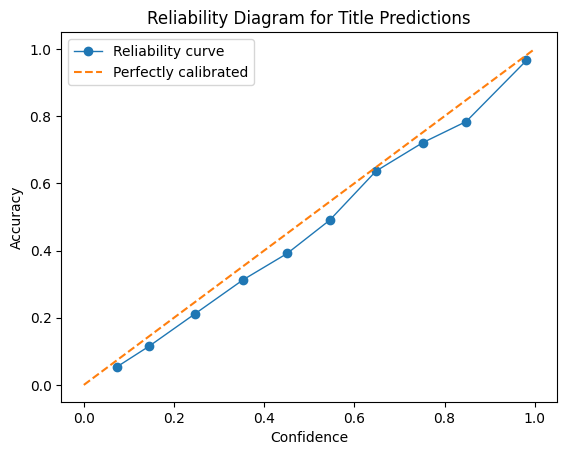

In [16]:
import matplotlib.pyplot as plt

def plot_reliability_diagram(predictions, labels, confidences, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies = (predictions == labels).astype(float)

    bin_accuracies = []
    bin_confidences = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            bin_accuracies.append(accuracy_in_bin)
            bin_confidences.append(avg_confidence_in_bin)

    plt.plot(bin_confidences, bin_accuracies, marker='o', linewidth=1, label='Reliability curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Confidence')
    plt.ylabel('Perceived Frequency')
    plt.title('Reliability Diagram for Title Predictions')
    plt.legend()
    plt.show()

# Example usage:
plot_reliability_diagram(predictions, labels, confidences)
